<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/MultiLabel_FL_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 213 kB 17.5 MB/s 
     |████████████████████████████████| 61 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 10.5 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

Importamos las librerías necesarias:

In [2]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

In [3]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-26 16:26:12 URL:https://uc8ac0e3058297690b5320c2ba1c.dl.dropboxusercontent.com/cd/0/inline2/Bn-jDM-tNcHLMvuAm2inEydivsw4TfgSk85uAZlg0UWuFwHpYdlYKw0sLdxkA4l0jo8wwQwE9CwTmcnjyBhof4ro0g7oc2Bk3Qj34BbPjmU-bhcozR1vFkCEuBpcivMSaS_-G-3Z_QNDWC60gTuoba2mWbJ-7p2mq-3oRFm4S9I491-ZXbrwkQ8zCxtniq_h1gnhilYdSgjlugUqLKqgCT1RxymlKKAqezTEQN8b_Q29jSfJOgjZqggf8DrQYLtoPObS4-SbRxbnirv83j3S4N2RgE6ZodjPKW1-g5Vqb7hREWyuFONFH53IfoU-BT5OVpskpXMd5Ce4CoxLfy4V8qhuCNVpZI7U9LaGHssG6CKsS1L2M2RwkRPuiI6A9lcFlVm-MCvgtpigETZNAuK24s4OqX7DqoqM9g95Tz1yDa5n7A/file [138777773/138777773] -> "train.zip" [1]
2022-06-26 16:26:15 URL:https://ucd294e9f2dd60b512d59304a2ac.dl.dropboxusercontent.com/cd/0/inline2/Bn_KxBJ60lvYoUqrgkv2odtNWUV8XxSV2G-WxkQbGpTMg5o_O8ReI42WSZw2PzSEmo3o51ISyRJoTZ0CrT8evhW176Ko2vYHw32f7B4p3QqsamEr0blE9Nng-2MkpvEWsGw7IZgj_oKujGCI0lnZxo2gvwiRQrIILccJx1Q7SRdZy5Hc5RYwopiEiMcWZVAhWCRw0sk5X7Zz1UrdTLFkxFA7koMUymLgGY3e_02AQObTjFsSXOONNfJBlZdQQHqsdI9izurSLjuBQap25b2oB1LSKiyUUmrhX-6tu3c8o5i2QP6IN2IBdzmMPYQK7KLTGmW

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [8]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [10]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [11]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH ODC
4,Training_Set_Pre/Training/5,DR LS
5,Training_Set_Pre/Training/6,ARMD MYA
6,Training_Set_Pre/Training/7,ARMD MYA
7,Training_Set_Pre/Training/8,ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [12]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [13]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [14]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH ODC,False
4,Training_Set_Pre/Training/5,DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [15]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [47]:
def conjuntoImg(nombreImg):
  return df[df.nombre_img == nombreImg[0]].is_valid.values[0]

In [48]:
df = df_train_val

In [49]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [19]:
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [50]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, suff='.png'),
                  splitter=FuncSplitter(conjuntoImg),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms = Resize(256),
                  batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [51]:
dls = db.dataloaders(df.values)

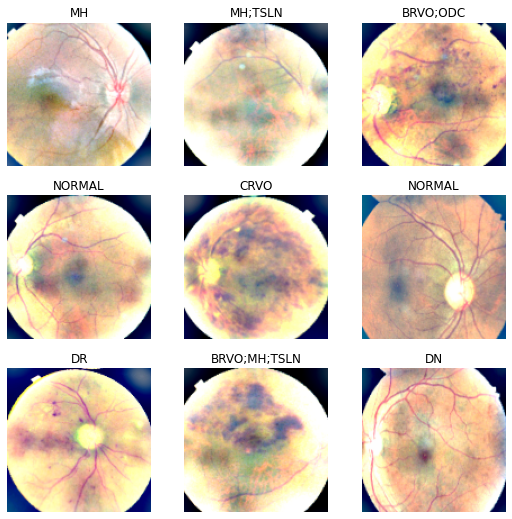

In [52]:
dls.show_batch()

## Entrenar Modelo

In [53]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [58]:
metrics = [ accuracy_multi, PrecisionMulti(), RecallMulti(), F1ScoreMulti() ]
learn = timm_learner(dls, 'vgg16', pretrained=True, metrics=metrics, loss_func=FocalLoss(), cbs=callbacks).to_fp16()

SuggestedLRs(minimum=0.010000000149011612, steep=0.0008317637839354575)

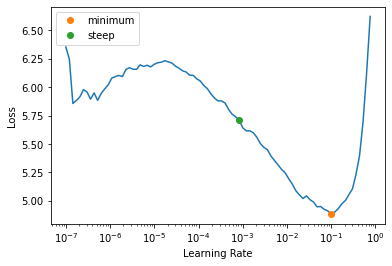

In [59]:
learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,4.693323,4.216153,0.513200,0.073013,0.714455,0.117899,00:09


Better model found at epoch 0 with valid_loss value: 4.216153144836426.


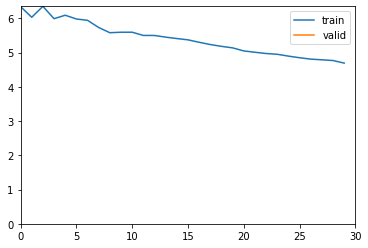

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,3.649777,3.772074,0.510668,0.071544,0.731246,0.117027,00:12
1,3.457717,3.978430,0.499784,0.071966,0.740547,0.117612,00:12
2,3.298535,3.627937,0.510668,0.071263,0.742168,0.117669,00:12
3,3.138097,3.631285,0.501778,0.070520,0.773714,0.117229,00:12
4,3.043262,3.498041,0.502640,0.071190,0.788044,0.118427,00:12
5,2.957664,3.395397,0.522953,0.072096,0.783751,0.120087,00:12
6,2.851824,3.412326,0.522414,0.070614,0.774804,0.118694,00:12
7,2.796445,3.324248,0.516918,0.073022,0.788751,0.122082,00:12
8,2.687202,3.366280,0.523384,0.073440,0.819636,0.123084,00:12
9,2.585403,3.470586,0.518373,0.070499,0.787698,0.118500,00:12


Better model found at epoch 0 with valid_loss value: 3.7720744609832764.


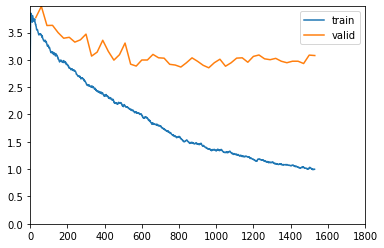

Better model found at epoch 2 with valid_loss value: 3.6279373168945312.
Better model found at epoch 4 with valid_loss value: 3.4980406761169434.
Better model found at epoch 5 with valid_loss value: 3.3953967094421387.
Better model found at epoch 7 with valid_loss value: 3.3242480754852295.
Better model found at epoch 10 with valid_loss value: 3.0683271884918213.
Better model found at epoch 14 with valid_loss value: 2.994678020477295.
Better model found at epoch 17 with valid_loss value: 2.9205026626586914.
Better model found at epoch 18 with valid_loss value: 2.886049509048462.
Better model found at epoch 26 with valid_loss value: 2.8680617809295654.
Better model found at epoch 31 with valid_loss value: 2.854407548904419.
No improvement since epoch 31: early stopping
CPU times: user 7min 17s, sys: 30.2 s, total: 7min 47s
Wall time: 11min 50s


In [60]:
%%time
learn.fine_tune(60,base_lr=1e-3)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


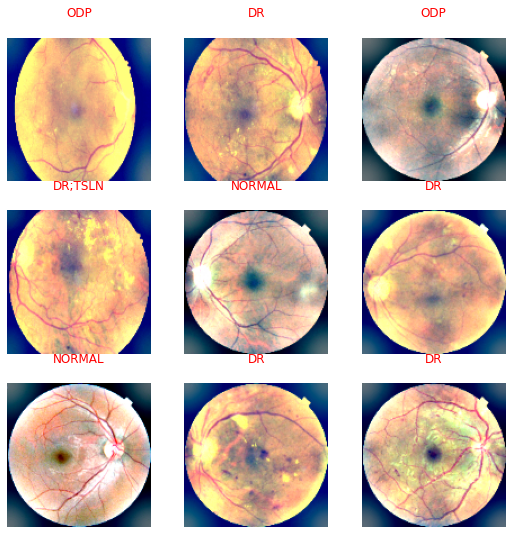

In [61]:
learn.show_results()

## Evaluar el modelo

In [62]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = Resize(256),
                   batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [63]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [64]:
learn.dls = dlsTest

In [65]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.5848599076271057.


(#5) [2.6939167976379395,0.5848599076271057,0.07375954132442294,0.7616210277214335,0.12780399379596186]

Exportamos el modelo

In [66]:
learn.to_fp32()
learn.export('MultiLabel_FL_vgg16.pkl')

## Comprobaciones manuales

In [67]:
learn_inf = load_learner('MultiLabel_FL_vgg16.pkl')

In [ ]:
df_test[df_test['Disease_Risk']==1] #enfermedad

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df_test[df_test['Disease_Risk']==0] #sanas
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Imágenes con enfermedad**

In [68]:
learn_inf.predict('Test_Set_Pre/Test/1.png')[0] #DR, TLSN

(#0) []

In [69]:
learn_inf.predict('Test_Set_Pre/Test/2.png')[0] #DR, BRVO

(#0) []

In [70]:
learn_inf.predict('Test_Set_Pre/Test/3.png')[0] #DR, ODC

(#0) []

In [71]:
learn_inf.predict('Test_Set_Pre/Test/10.png')[0] #DR, LS, ODC

(#0) []

**Imágenes normales:**

In [72]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#0) []

In [73]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#0) []

In [74]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#0) []

In [75]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#0) []

In [76]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#0) []